In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from array import array
from os.path  import join
import time

# Load MNIST data

In [2]:
# Reference: 
# https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download
# https://www.kaggle.com/code/hojjatk/read-mnist-dataset 

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  


#
# Set file paths based on added MNIST Datasets
#
input_path = './data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [3]:
X_train = np.array(x_train)
y_train = np.array(y_train)

X_test = np.array(x_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


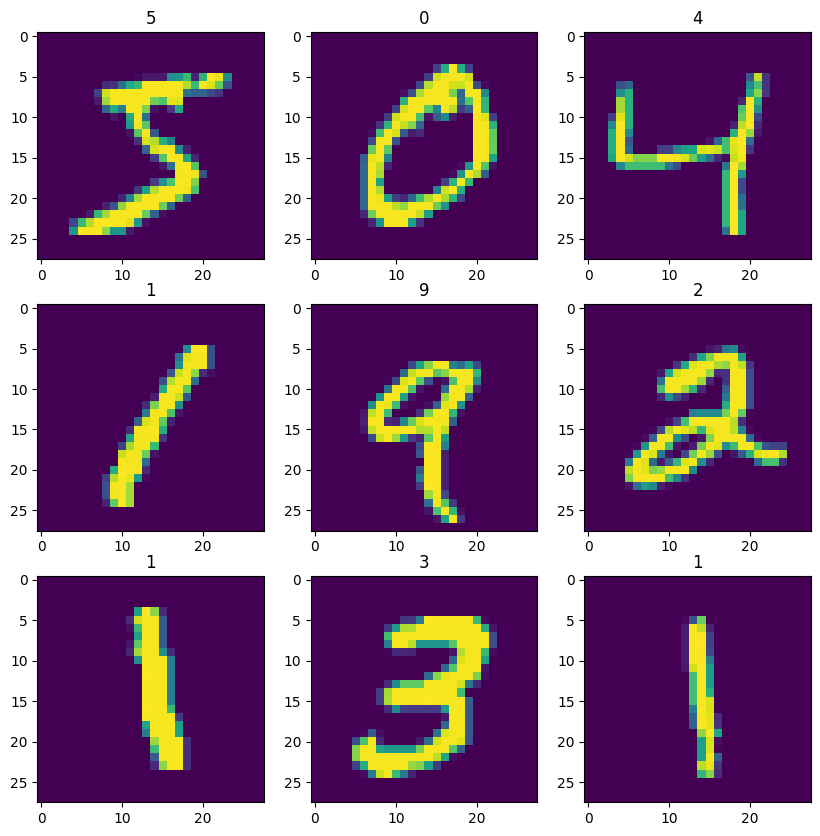

In [4]:
# check some examples

plt.subplots(3, 3, figsize=[10,10])
for i in range(9):
    image = X_train[i]
    label = y_train[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(label)
plt.show()

# Preprocessing

In [5]:
# check data range
X_train.min(), X_train.max()

(0, 255)

In [6]:
# number of classes
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
# normalize

X_mean = np.mean(X_train / 255.)
X_std = np.std(X_train / 255.)

X_train_nrm = ((X_train / 255.) - X_mean)/X_std

X_train_nrm.min(), X_train_nrm.max()

(-0.4240738943915667, 2.8215433456893395)

# Define CNN model

In [8]:
input_size = 28     # image size is 28x28
output_size = 10    # 10 classes 

### model design
# convolutional layer
# relu
# average pooling layer
# flatten
# fully connected layer 1
# relu
# fully connected layer 2
# softmax
###

### configuration
conv_kernel_size = 5
avg_pool_kernel_size = 2
avg_pool_slide = 2
fc1_hidden_size = 50
###

In [9]:
def conv(X, W, b):
    # X[:, :, :]. First index is data index. Next two are spatial indices
    # W[:,:] of shape (conv_kernel_size, conv_kernel_size)
    # b[:,] of shape (1,)
    # assume no padding

    I, J = X[0].shape
    batch_size = X.shape[0]
    output = np.zeros((batch_size, I-(conv_kernel_size-1), J-(conv_kernel_size-1)))

    for i in range(I-(conv_kernel_size-1)):
        for j in range(J-(conv_kernel_size-1)):
            X_slice = X[:, i:i+conv_kernel_size, j:j+conv_kernel_size]
            output[:, i, j] = np.sum(X_slice * W, axis=(1,2)) + b

    return output

def relu(X):
    return np.maximum(X, 0.)

In [10]:
def avg_pool(X):
    # X[:, :, :]
    # assume no padding

    I, J = X[0].shape
    batch_size = X.shape[0]
    out_I = int((I-avg_pool_kernel_size)/avg_pool_slide+1)
    out_J = int((J-avg_pool_kernel_size)/avg_pool_slide+1)
    output = np.zeros((batch_size, out_I, out_J))

    for i in range(out_I):
        for j in range(out_J): 
            X_slice = X[:, i*avg_pool_slide:i*avg_pool_slide+avg_pool_kernel_size, j*avg_pool_slide:j*avg_pool_slide+avg_pool_kernel_size]
            output[:, i, j] = np.mean(X_slice, axis=(1,2))

    return output

In [11]:
def flatten(X):
    # X[:, i, j] -> X[:, i*J + j]
    batch_size = X.shape[0]
    # I, J = X[0].shape

    # index_map = {}
    # rev_index_map = {}
    # for i in range(I):
    #     for j in range(J):
    #         new = i*J + j
            # index_map[(i, j)] = new
            # rev_index_map[new] = (i, j)

    return X.reshape(batch_size, -1)#, index_map, rev_index_map

In [12]:
def fc(X, W, b):
    # fully-connected layer (linear)
    # X[:, in_shape]
    # W[out_shape, in_shape]
    # b[out_shape]

    return (X @ W.T + b)


def softmax(X):
    # X[:, num_classes]

    X_max = X.max(axis=1, keepdims=True)
    X_transform = X - X_max     # prevent overflow
    return np.exp(X_transform) / (np.sum(np.exp(X_transform), axis=1, keepdims=True) + 1e-8)



In [13]:
def cross_entropy_loss(y, p, num_class):
    # y[:,] true labels
    # p[:, c] predicted probabilities
    y_binary = np.eye(num_class)[y]
    return (- y_binary * np.log(p + 1e-8)).sum(axis=1)

In [14]:

def d_cross_entropy_softmax(y, p, num_class):
    # Derivatives of the loss function with respect to the input of softmax
    # y[:,] true labels
    # p[:, num_class] predicted probabilities
    # return shape: (:, num_class)

    y_binary = np.eye(num_class)[y] 
    return p - y_binary

In [15]:
def d_avg_pool(d_out, input_shape):
    # d_out: derivatives wrt to the output of avg pooling layer
    # return: derivatives wrt to the input of avg pooling layer

    I_in, J_in = input_shape
    I_out, J_out = d_out[0].shape
    batch_size = d_out.shape[0]
    weight = avg_pool_kernel_size ** 2

    d_in = np.zeros((batch_size, I_in, J_in))

    for i in range(I_out):
        for j in range(J_out):
            d_in[:, i*avg_pool_slide:i*avg_pool_slide+avg_pool_kernel_size, j*avg_pool_slide:j*avg_pool_slide+avg_pool_kernel_size] \
                += (weight * d_out[:, i, j]).reshape(-1, 1, 1)
    
    return d_in

In [16]:
def d_conv(d_out, X):
    # d_out: derivatives wrt to the output of conv layer
    # return: derivatives wrt to the kernel weights

    batch_size = d_out.shape[0]
    I_out, J_out = d_out[0].shape

    d_W = np.zeros((batch_size, conv_kernel_size, conv_kernel_size))

    for i in range(I_out):
        for j in range(J_out):
            d_W += d_out[:, i, j].reshape(-1, 1, 1) * X[:, i:i+conv_kernel_size, j:j+conv_kernel_size]
    return d_W

# Train

In [17]:
### Initialize parameters

np.random.seed(101)

W_conv = np.random.uniform(-1/conv_kernel_size, 1/conv_kernel_size, conv_kernel_size**2).reshape(conv_kernel_size, conv_kernel_size)
b_conv = np.random.uniform(-1/conv_kernel_size, 1/conv_kernel_size,1)

pool_output_size = int((input_size-(conv_kernel_size-1)-avg_pool_kernel_size)/avg_pool_slide+1)
fc1_input_size = pool_output_size**2

r_fc1 = 1/np.sqrt(fc1_hidden_size)
W_fc1 = np.random.uniform(-r_fc1, r_fc1, fc1_input_size*fc1_hidden_size).reshape(fc1_hidden_size, fc1_input_size)
b_fc1 = np.random.uniform(-r_fc1, r_fc1, fc1_hidden_size)

r_fc2 = 1/np.sqrt(output_size)
W_fc2 = np.random.uniform(-r_fc2, r_fc2, output_size*fc1_hidden_size).reshape(output_size, fc1_hidden_size)
b_fc2 = np.random.uniform(-r_fc2, r_fc2, output_size)



#### Training ####

# training config
lr = 5e-3
# 1e-3
num_epochs = 30
batch_size = 1000
validation_size = 0.2
# 


# Random split into training and validation
all_ind = np.arange(len(y_train))
np.random.shuffle(all_ind)

train_ind = all_ind[:int(len(y_train)*(1-validation_size))]
valid_ind = all_ind[int(len(y_train)*(1-validation_size)):]

num_batches = len(train_ind) // batch_size

loss_epochs = []
acc_epochs = []

valid_loss_epochs = []
valid_acc_epochs = []


# training starts here
for epoch in range(num_epochs):
    start = time.time()
    np.random.shuffle(train_ind)
    loss_batch = []
    y_true_batch = []
    y_pred_batch = []

    for b in range(num_batches):
        # if (b+1) % 10 == 1:
        #     print(f"Batch {b+1}/{num_batches}")
        
        X = X_train_nrm[train_ind[b*batch_size:(b+1)*batch_size]]
        y = y_train[train_ind[b*batch_size:(b+1)*batch_size]]

        ### forward propagation
        conv_out = relu(conv(X, W_conv, b_conv))
        pool_out = avg_pool(conv_out)
        flatten_out = flatten(pool_out)
        fc1_out = relu(fc(flatten_out, W_fc1, b_fc1))
        fc2_out = fc(fc1_out, W_fc2, b_fc2)
        prob = softmax(fc2_out)

        y_true_batch.append(y)
        y_pred_batch.append(prob.argmax(axis=1))

        ### loss
        loss = cross_entropy_loss(y, prob, output_size)
        loss_batch.append(loss)

        # break


        ### backward propagation

        ## FC2
        grad_fc2_out = d_cross_entropy_softmax(y, prob, output_size)
        d_b_fc2 = grad_fc2_out
        d_W_fc2 = np.einsum("bi,bj->bij", grad_fc2_out, fc1_out)

        ## FC1
        grad_fc1_out = grad_fc2_out @ W_fc2
        d_b_fc1 = grad_fc1_out * (fc1_out >= 0.)
        d_W_fc1 = np.einsum("bi,bj->bij", grad_fc1_out *(fc1_out >= 0.), flatten_out)

        ## Flatten + pool
        grad_flatten_out = (grad_fc1_out *(fc1_out >= 0.)) @ W_fc1
        grad_pool_out = grad_flatten_out.reshape(-1, pool_output_size, pool_output_size)

        ## Conv
        grad_conv_out = d_avg_pool(grad_pool_out, (input_size-(conv_kernel_size-1), input_size-(conv_kernel_size-1)))
        d_b_conv = np.sum(grad_conv_out * (conv_out >= 0.), axis=(1,2))
        d_W_conv = d_conv(grad_conv_out * (conv_out >= 0.), X)


        ### Update weights
        W_fc2 -= d_W_fc2.mean(axis=0) * lr
        b_fc2 -= d_b_fc2.mean(axis=0) * lr

        W_fc1 -= d_W_fc1.mean(axis=0) * lr
        b_fc1 -= d_b_fc1.mean(axis=0) * lr

        W_conv -= d_W_conv.mean(axis=0) * lr
        b_conv -= d_b_conv.mean(axis=0) * lr
    
    # break
    
    avg_loss = np.concatenate(loss_batch).mean()
    loss_epochs.append(avg_loss)

    y_true = np.concatenate(y_true_batch)
    y_pred = np.concatenate(y_pred_batch)
    acc = (y_true == y_pred).mean()
    acc_epochs.append(acc)


    ### Get predictions on hold-out validation data
    X_valid = X_train_nrm[valid_ind]
    y_valid = y_train[valid_ind]

    def predict(X_input):
        conv_out = relu(conv(X_input, W_conv, b_conv))
        pool_out = avg_pool(conv_out)
        flatten_out = flatten(pool_out)
        fc1_out = relu(fc(flatten_out, W_fc1, b_fc1))
        fc2_out = fc(fc1_out, W_fc2, b_fc2)
        prob = softmax(fc2_out)
        return prob
    
    p_valid = predict(X_valid)
    valid_loss = cross_entropy_loss(y_valid, p_valid, output_size).mean()
    valid_acc = (y_valid == p_valid.argmax(axis=1)).mean()
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # learning rate annealing
    if (epoch+1) % 10 == 0:
        lr /= 2

    end = time.time()
    print(f"Epoch {epoch}, avg loss {avg_loss:.5f}, accuracy {acc*100:.2f}%, valid avg loss {valid_loss:.5f}, valid accuracy {valid_acc*100:.2f}%, time taken {end-start:.2f} s")

Epoch 0, avg loss 2.33248, accuracy 11.08%, valid avg loss 2.25231, valid accuracy 17.03%, time taken 43.22 s
Epoch 1, avg loss 2.00033, accuracy 36.06%, valid avg loss 1.70495, valid accuracy 51.25%, time taken 41.75 s
Epoch 2, avg loss 2.40788, accuracy 55.41%, valid avg loss 1.63433, valid accuracy 64.84%, time taken 47.64 s
Epoch 3, avg loss 2.09488, accuracy 64.80%, valid avg loss 1.12379, valid accuracy 76.04%, time taken 42.34 s
Epoch 4, avg loss 1.65982, accuracy 70.81%, valid avg loss 4.54323, valid accuracy 54.97%, time taken 33.10 s
Epoch 5, avg loss 1.45632, accuracy 73.95%, valid avg loss 1.35944, valid accuracy 74.83%, time taken 33.96 s
Epoch 6, avg loss 1.17084, accuracy 77.22%, valid avg loss 1.13024, valid accuracy 77.88%, time taken 20.29 s
Epoch 7, avg loss 1.74676, accuracy 72.09%, valid avg loss 1.21611, valid accuracy 76.10%, time taken 26.08 s
Epoch 8, avg loss 0.98795, accuracy 79.80%, valid avg loss 1.00404, valid accuracy 79.96%, time taken 27.02 s
Epoch 9, a

Text(0.5, 1.0, 'loss')

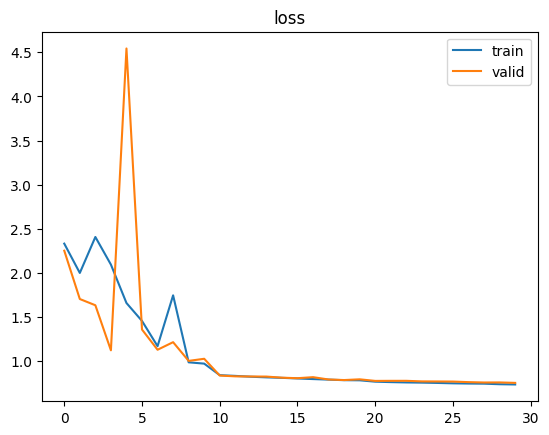

In [18]:
plt.plot(loss_epochs, label="train")
plt.plot(valid_loss_epochs, label="valid")
plt.legend()
plt.title("loss")

Text(0.5, 1.0, 'accuracy')

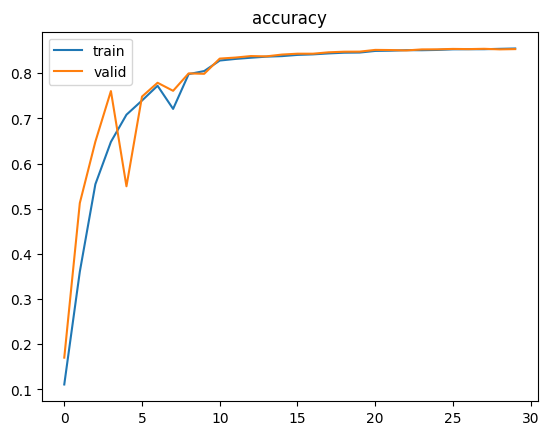

In [19]:
plt.plot(acc_epochs, label="train")
plt.plot(valid_acc_epochs, label="valid")
plt.legend()
plt.title("accuracy")

# Get preditions on test data

In [20]:
print(X_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


In [21]:
X_test_nrm = ((X_test / 255.) - X_mean)/X_std

In [22]:
probabilities = predict(X_test_nrm)
predictions = probabilities.argmax(axis=1)

In [23]:
test_accuracy = (y_test == predictions).mean()
print(f"Accuracy on test data: {test_accuracy*100:.2f}%")

Accuracy on test data: 86.28%


In [59]:
def get_confusion_matrix(y_true, y_pred, num_classes):

    y_merge = np.concatenate([y_true.reshape(-1, 1), y_pred.reshape(-1, 1)], axis=1)
    indices, counts = np.unique(y_merge, axis=0, return_counts=True)

    mat = np.zeros((num_classes, num_classes), dtype=int)

    for ind, cnt in zip(indices, counts):
        mat[ind[0], ind[1]] = cnt

    return mat

In [60]:
confusion_matrix = get_confusion_matrix(y_test, predictions, output_size)

In [61]:
confusion_matrix.dtype

dtype('int64')

In [62]:
import seaborn as sns

Text(0.5, 36.72222222222221, 'Predicted')

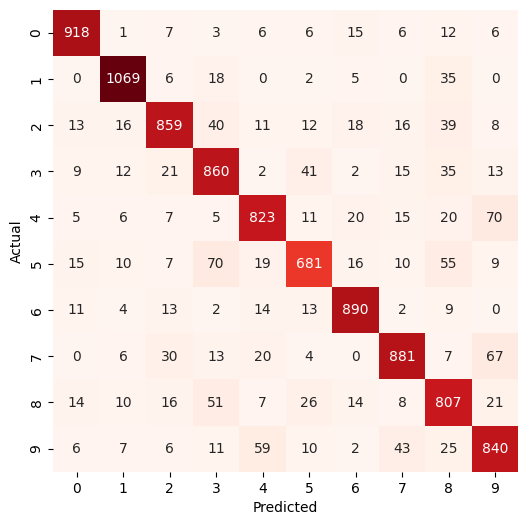

In [64]:
plt.figure(figsize=[6,6])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cbar=False, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')